In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Importing the FashionMNIST dataset and splitting into training and testing dataset
train_dataset = pd.read_csv('//uofa/users$/users9/a1876729/Downloads/CNN assignment/fashion-mnist_train.csv')
test_dataset = pd.read_csv('//uofa/users$/users9/a1876729/Downloads/CNN assignment/fashion-mnist_test.csv')

X_train = train_dataset.iloc[:,1:].values
Y_train = train_dataset.label.values

X_test = test_dataset.iloc[:,1:].values
Y_test = test_dataset.label.values

print(X_test.shape, X_train.shape)


(10000, 784) (60000, 784)


[42793 38810 17409 18626  2994 35777 53096 43985]


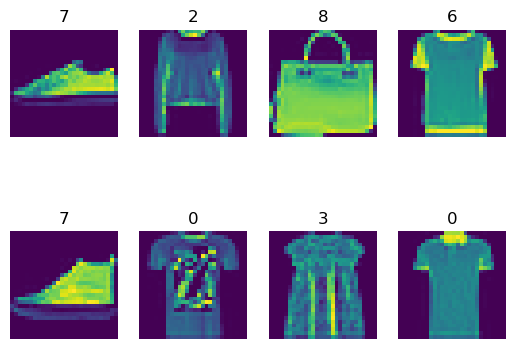

In [7]:
# visualizing a few images 
sample = np.random.randint(0,high= 59999, size=8)
print(sample)
sample_img = X_train[sample, :]
sample_label = Y_train[sample]
for i , img in enumerate(sample_img):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    plt.title(sample_label[i])
    img = img.reshape(28,28)
    plt.imshow(img)
plt.show()

In [8]:
#Defining the constants
epochs = 5
batch_size = 100
data_augmentation = False
img_size = 28

num_classes = 10
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

In [9]:
x_train = X_train.reshape(X_train.shape[0],img_size,img_size,1)
x_test = X_test.reshape(X_test.shape[0],img_size,img_size,1)
input_size = (img_size, img_size,1)

# Normalizing the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('Y_train shape:', Y_train.shape)

#Converting the labels to one-hot vectors
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test,num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Y_train shape: (60000,)


In [10]:
#Creating the model based on ResNet published architecture
inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Checking by applying max pooling
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3


# Creating Conv base stack 
# Initiating the convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Adding classifier on top
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compiling the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 14, 14, 64)   0           ['batch_normalization[0][0]']

                                                                                                  
 batch_normalization_9 (BatchNo  (None, 4, 4, 256)   1024        ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 4, 4, 256)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_11 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_9[0][0]']           
                                                                                                  
 conv2d_12 (Conv2D)             (None, 4, 4, 256)    33024       ['activation_8[0][0]']           
                                                                                                  
 batch_nor

In [11]:
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_resnet_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)

U:\Downloads\CNN assignment\saved_model\fmnist_resnet_model.h5


In [12]:
# Preparing the callbacks for model saving and for learning rate decaying
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

In [13]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Not using data augmentation.
Epoch 1/5
600/600 [==============================] - ETA: 0s - loss: 1.1997 - accuracy: 0.8521
Epoch 1: val_loss improved from inf to 0.95593, saving model to U:\Downloads\CNN assignment\saved_model\fmnist_resnet_model.h5
600/600 [==============================] - 716s 1s/step - loss: 1.1997 - accuracy: 0.8521 - val_loss: 0.9559 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 2/5
600/600 [==============================] - ETA: 0s - loss: 0.7623 - accuracy: 0.8969
Epoch 2: val_loss improved from 0.95593 to 0.69588, saving model to U:\Downloads\CNN assignment\saved_model\fmnist_resnet_model.h5
600/600 [==============================] - 714s 1s/step - loss: 0.7623 - accuracy: 0.8969 - val_loss: 0.6959 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 3/5
600/600 [==============================] - ETA: 0s - loss: 0.5854 - accuracy: 0.9100
Epoch 3: val_loss improved from 0.69588 to 0.56072, saving model to U:\Downloads\CNN assignment\saved_model\fmnist_resnet_model.h5
600/600

In [14]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 16s 49ms/step - loss: 0.4741 - accuracy: 0.9107
Test loss: 0.4740753471851349
Test accuracy: 0.9107000231742859
